Epoch 1, Loss: 1.7725393772125244, Accuracy: 31.488889694213867, Test Accuracy: 30.66132354736328
[-0.37839627 -0.23019639  0.00235272  0.55321634  0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 21, Loss: 1.526656150817871, Accuracy: 40.68888854980469, Test Accuracy: 38.6773567199707
[ 0.30762318  0.00603966  0.00235272  0.69696915  0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 41, Loss: 1.4855239391326904, Accuracy: 41.80000305175781, Test Accuracy: 39.078155517578125
[ 0.5509553   0.00603966  0.00235272  0.6992117   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 61, Loss: 1.3864818811416626, Accuracy: 41.93333435058594, Test Accuracy: 39.8797607421875
[ 0.6096995   0.00603966  0.00235272  0.72213703  0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 81, Loss: 1.3515276908874512, Accuracy: 40.133331298828125, Test Accuracy: 37.87575149536133
[ 0.6379628   0.00603966  0

Epoch 761, Loss: 1.101017951965332, Accuracy: 57.93333053588867, Test Accuracy: 56.11222457885742
[ 0.630276    0.5284795   0.00235272  0.68432415  0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 781, Loss: 1.0977141857147217, Accuracy: 57.666664123535156, Test Accuracy: 55.31061935424805
[ 0.63217163  0.52582943  0.00235272  0.6824544   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 801, Loss: 1.0946637392044067, Accuracy: 57.55555725097656, Test Accuracy: 55.51102066040039
[ 0.6328773   0.52375543  0.00235272  0.6809025   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 821, Loss: 1.0918554067611694, Accuracy: 57.355552673339844, Test Accuracy: 55.31061935424805
[ 0.63255805  0.5221164   0.00235272  0.6796579   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 841, Loss: 1.089263677597046, Accuracy: 57.13333511352539, Test Accuracy: 54.308616638183594
[ 0.6312929   0.5207

Epoch 1521, Loss: 1.037035584449768, Accuracy: 54.511112213134766, Test Accuracy: 48.296592712402344
[ 0.45538306  0.5153574   0.00235272  0.6807117   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 1541, Loss: 1.0365397930145264, Accuracy: 54.511112213134766, Test Accuracy: 48.69739532470703
[ 0.45437458  0.5151691   0.00235272  0.68003005  0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 1561, Loss: 1.0360631942749023, Accuracy: 54.622222900390625, Test Accuracy: 49.09819793701172
[ 0.45340654  0.51497823  0.00235272  0.6793448   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 1581, Loss: 1.0356043577194214, Accuracy: 54.71110916137695, Test Accuracy: 49.09819793701172
[ 0.45247495  0.5147847   0.00235272  0.6786554   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 1601, Loss: 1.0351617336273193, Accuracy: 54.73333740234375, Test Accuracy: 49.2985954284668
[ 0.45157745  

Epoch 2261, Loss: 1.0254815816879272, Accuracy: 55.133331298828125, Test Accuracy: 49.699398040771484
[ 0.43230423  0.5077239   0.00235272  0.65582895  0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 2281, Loss: 1.0252703428268433, Accuracy: 55.11111068725586, Test Accuracy: 49.699398040771484
[ 0.43189982  0.5075199   0.00235272  0.655207    0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 2301, Loss: 1.0250613689422607, Accuracy: 55.133331298828125, Test Accuracy: 49.499000549316406
[ 0.43150213  0.50731593  0.00235272  0.65458846  0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 2321, Loss: 1.024855613708496, Accuracy: 55.155555725097656, Test Accuracy: 49.499000549316406
[ 0.43111125  0.5071128   0.00235272  0.65397245  0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 2341, Loss: 1.0246520042419434, Accuracy: 55.155555725097656, Test Accuracy: 49.499000549316406
[ 0.4307

Epoch 3001, Loss: 1.018985390663147, Accuracy: 55.35555648803711, Test Accuracy: 50.10020065307617
[ 0.42059115  0.500677    0.00235272  0.63503504  0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 3021, Loss: 1.0188367366790771, Accuracy: 55.35555648803711, Test Accuracy: 50.10020065307617
[ 0.42034465  0.50050235  0.00235272  0.6345348   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 3041, Loss: 1.0186893939971924, Accuracy: 55.35555648803711, Test Accuracy: 50.10020065307617
[ 0.42010108  0.50032747  0.00235272  0.6340362   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 3061, Loss: 1.0185433626174927, Accuracy: 55.35555648803711, Test Accuracy: 50.10020065307617
[ 0.41986045  0.50015384  0.00235272  0.6335408   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 3081, Loss: 1.0183976888656616, Accuracy: 55.35555648803711, Test Accuracy: 50.10020065307617
[ 0.41962242  0.4

Epoch 3761, Loss: 1.013932466506958, Accuracy: 55.4666633605957, Test Accuracy: 50.30060577392578
[ 0.41297174  0.49455234  0.00235272  0.6180082   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 3781, Loss: 1.01381254196167, Accuracy: 55.44444274902344, Test Accuracy: 50.30060577392578
[ 0.4128132   0.49440518  0.00235272  0.6176129   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 3801, Loss: 1.0136926174163818, Accuracy: 55.44444274902344, Test Accuracy: 50.30060577392578
[ 0.41265696  0.49425918  0.00235272  0.6172213   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 3821, Loss: 1.0135736465454102, Accuracy: 55.4666633605957, Test Accuracy: 50.30060577392578
[ 0.4125029   0.49411353  0.00235272  0.6168318   0.08234973  0.436112
  0.33039588  0.29468802 -0.8753699   0.16783257]
Epoch 3841, Loss: 1.0134549140930176, Accuracy: 55.44444274902344, Test Accuracy: 50.10020065307617
[ 0.41235027  0.49396

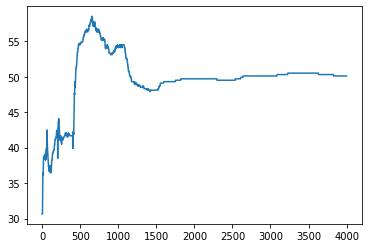

In [3]:
# hybrid model L_S 

# P 05
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt

class LSLayer(tf.keras.layers.Layer):
    
    def __init__(self,  num_outputs_s, num_outputs_r, num_outputs_l, activation=sigmoid, wstd = 0.3, bstd = 0.5):
        super(LSLayer, self).__init__()
        self.num_outputs_l = num_outputs_l
        self.num_outputs_s = num_outputs_s 
        self.num_outputs_r = num_outputs_r
        self.num_outputs = num_outputs_l + num_outputs_s + num_outputs_r
        self.activation = activation
        self.wstd = wstd
        self.bstd = bstd
        
    def build(self, input_shape):  
        self.num_inputs = input_shape[-1]
        self.kernel = self.add_weight("kernel",
                                      shape=(int(input_shape[-1]),
                                             self.num_outputs), 
                                      initializer=tf.keras.initializers.RandomNormal(stddev=self.wstd),
                                     trainable=True)

        self.bias = self.add_weight("bias",
                                      shape=[self.num_outputs],
                                    initializer=tf.keras.initializers.RandomNormal(stddev=self.bstd),
                                   trainable=True)
        
    
    # F2 method LS layer
    def call(self, input):
        
        isp = input.shape
        In1 = tf.transpose(input)
        kernel_S, kernel_L  = tf.split(self.kernel,[ self.num_outputs_s + self.num_outputs_r, self.num_outputs_l ], axis = 1 )
        bias_S, bias_L  = tf.split(self.bias,[ self.num_outputs_s +  self.num_outputs_r, self.num_outputs_l ], axis = 0 )
        
        # case spherical
        
        s_shape  = self.num_outputs_s + self.num_outputs_r
        In2 = tf.stack([In1] * s_shape)
        InD = tf.transpose(In2)
        WD = tf.stack([kernel_S] * isp[0])
        ddd = WD - InD
        dd0 = tf.math.multiply(ddd, ddd)
        dd1 = tf.math.reduce_sum(dd0, axis =1)
        dd2 = tf.cast(dd1,tf.double)
        dd3 = tf.sqrt(dd2)
        d_r = tf.cast(dd3,tf.float32)
        d_R = tf.abs(bias_S)
        d_rR = tf.math.divide_no_nan(d_r,d_R)
        d_x0 = tf.ones(d_rR.shape) - d_rR
        result_S = tf.math.scalar_mul(6,d_x0)
        result_S = sigmoid(result_S)
        
        # case linear

        d_1 = tf.stack([bias_L] * isp[0])
        result_L = tf.matmul(input, kernel_L) + d_1 
        result_L = relu(result_L)

        #case empty, merge
        
        if self.num_outputs_r > 0:
            r_S, _ = tf.split (result_S,[self.num_outputs_s, self.num_outputs_r],axis=1 )
            r_1 = np.zeros((result_S.shape[0],self.num_outputs_r))
            result_R = tf.cast(tf.constant(r_1),tf.float32)
            result = tf.concat([r_S, result_R, result_L],axis=1)            
        else:
            result = tf.concat([result_S, result_L],axis=1)        
        
        return result
    

class NN_Model(Model):
    
    def __init__(self,c,hs,hr,hl):
        super(NN_Model, self).__init__()
        self.d1 = LSLayer(hs,hr,hl)
        self.d2 = Dense(c)

    def call(self, x):
        x = self.d1(x)
        #print ("call benn:",x, tf.math.reduce_sum(x))
        return self.d2(x)
        


@tf.function
def train_step(datas, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(datas, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(datas, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    predictions = model(datas, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    
    
def update_NN_model (model, train_ds):

    rdb = 0
    odb = 0
    N = min(2, model.d1.num_outputs_r)   # number of new SSN nodes
    
    if N <= 0:
        return
    
    baditems = []
    for datas, labels in train_ds:
        predictions = model(datas, training=False)
        for i in range(datas.shape[0]):
            #print (datas.numpy()[i], predictions.numpy()[i], np.argmax(predictions.numpy()[i]), labels.numpy()[i],np.argmax(labels.numpy()[i]))
            if np.argmax(predictions.numpy()[i]) != np.argmax(labels.numpy()[i]):
                rdb = rdb + 1
                baditems.append(datas.numpy()[i])
            odb = odb + 1        
    #print ("pontossag:",(odb-rdb)/odb, len(baditems))
    inds = random.sample(range(len(baditems)), N)

    neww = np.zeros((model.d1.num_inputs,N))
    for i in range(N):
        for j in range(model.d1.num_inputs):
            neww[j,i] = baditems[inds[i]][j]

    newb = np.zeros((N))
    for i in range(N):
        newb[i] = random.random()*model.d1.bstd
 
    xu = model.d1.get_weights()
    
    for j in range(N):
        for i in range(xu[0].shape[0]):
            xu[0][i][model.d1.num_outputs_s + j] = neww[i,j]
        xu[1][j] = newb[j]
            
    model.d1.set_weights(xu )
    
    model.d1.num_outputs_s = model.d1.num_outputs_s + N
    model.d1.num_outputs_r = model.d1.num_outputs_r - N

C= 6
L= 50
N= 5000
M= 6
HS = 4
HR = 6
HL = 0
EPOCHS = 4000

# Create an instance of the model
model = NN_Model(C,HS,HR,HL)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

(x_train,y_train,x_test,y_test) = gen_data_array(C, L, N, M)
#print (x_train[:2])
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32)
#print (train_ds)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

    


X = []
Y = []
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch

    if epoch > 1:
        xu2 = model.d1.get_weights()
        #print ("WW",epoch, "WW", xu2[0])

    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for datas, labels in train_ds:
        train_step(datas, labels)
        
                
    for test_datas, test_labels in test_ds:
        #print ("test_data_shape", test_datas.shape)
        predictions = model(test_datas, training=False)
        #print ("ttttttttttttttttttt")
        #for i in range(test_datas.shape[0]):
        #    print (predictions.numpy()[i], test_labels.numpy()[i])
        test_step(test_datas, test_labels)
        
    if epoch % 200 == 3:
        update_NN_model (model, train_ds)
        
        
    X.append(epoch)
    Y.append(test_accuracy.result() * 100)
    if epoch % 20 == 0:
        print(
            f'Epoch {epoch + 1}, '
            f'Loss: {train_loss.result()}, '
            f'Accuracy: {train_accuracy.result() * 100}, '
            f'Test Accuracy: {test_accuracy.result() * 100}'
          )    
        print(model.d1.bias.numpy())


print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )    

    
plt.plot(X, Y,label="Accuracy curve")



In [25]:
import statistics 

x = [82,97,81,75,86,85,76,86,92,82]
print (sum(x)/len(x), statistics.stdev(x))

84.2 6.696599468718765


In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_blobs
import numpy as np
import random 


tf.enable_eager_execution()


def gen_cluster_data_list(Cv, Lv, Nv, Mv):
    Tr = []
    Ts = []
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    X, y = make_blobs(n_samples=N, centers=L, n_features=M,cluster_std=.5, random_state=11)
    cmap = []
    for _ in range(L):
        cmap.append(random.randint(0,C-1))
    cols = []
    for i in range(N):
        cols.append(cmap[y[i]])

    for i in range(int(0.9*N)):
        row = [X[i,j] for j in range(M)]
        row.append(cols[i])
        Tr.append(row)
    
    for i in range(int(0.9*N)+1,N):
        row = [X[i,j] for j in range(M)]
        row.append(cols[i])
        Ts.append(row)
        
    return (Tr, Ts)

def normalize (train):
    mx = []
    mn = []
    for i in range(len(train[0])-1):
        mx.append(max([x[i] for x in train ]))
        mn.append(min([x[i] for x in train ]))
    for row in train:
        for i in range(len(row)-1):
            row[i] = (row[i] - mn[i]) / (mx[i] - mn[i]) 
    return train


def gen_data_array(Cv, Lv, Nv, Mv):
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    (T1,T2)  = gen_cluster_data_list(C, L, N, M)

    T = normalize(T1)
    N = len(T)
    x2_train = np.zeros((N,M),dtype='float32')
    y2_train = np.zeros((N,C))
    for i in range(N):
        row = T[i]
        for j in range(M):
            x2_train[i,j] = row[j]
        y2_train[i,row[-1]] = 1

    Ts = normalize(T2)
    Ns = len(Ts)
    x2_test = np.zeros((Ns,M),dtype='float32')
    y2_test = np.zeros((Ns,C))
    for i in range(Ns):
        row = Ts[i]
        for j in range(M):
            x2_test[i,j] = row[j]
        y2_test[i, row[-1]] = 1
        
    return (x2_train,y2_train, x2_test, y2_test)

def gen_data_array_s(Cv, Lv, Nv, Mv):
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    (T1,T2)  = gen_cluster_data_list(C, L, N, M)

    T = normalize(T1)
    N = len(T)
    x2_train = np.zeros((N,M),dtype='float32')
    y2_train = np.zeros((N,1))
    for i in range(N):
        row = T[i]
        for j in range(M):
            x2_train[i,j] = row[j]
        y2_train[i] = row[-1]

    Ts = normalize(T2)
    Ns = len(Ts)
    x2_test = np.zeros((Ns,M),dtype='float32')
    y2_test = np.zeros((Ns,1))
    for i in range(Ns):
        row = Ts[i]
        for j in range(M):
            x2_test[i,j] = row[j]
        y2_test[i] = row[-1]
        
    return (x2_train,y2_train, x2_test, y2_test)

